In [46]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy import stats
from scipy.stats import norm

In [2]:
plt.rcParams['svg.fonttype'] = 'none'

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [74]:
def create_scatter_plot(X, Y, x_title, y_title):
    
    scatter_df = pd.DataFrame({x_title: X, y_title: Y})
    
    fig, ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(data=scatter_df, x=x_title, y=y_title, s=35, ax=ax)
    
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        #np.max([0.8, 0.8]),  # max of both axes
    ]
    plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    return fig

In [3]:
def create_histogram(data, x_title, y_title, h_range, fraction):
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    
    data_size = len(data)
    class_size = int(data_size * fraction)
    x_sens = data[class_size - 1]
    x_resist = data[data_size - class_size]
    
    plt.hist(x=[data[i] for i in range(class_size)], bins=9, rwidth=0.85)
    plt.hist(x=[data[i] for i in range(data_size - class_size, data_size)], bins=9, rwidth=0.85)
    plt.hist(x=[data[i] for i in range(class_size, data_size - class_size)], bins=2, color='darkgrey', rwidth=0.85)
    
    mu, std = norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    
    plt.axvline(x_sens, linewidth=2, color='black')
    plt.axvline(x_resist, linewidth=2, color='black')
    
    ax.grid(False)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [4]:
def create_line_curve(X, Y, x_title, y_title, x_lim, y_lim):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.plot(X, Y)
    ax.grid(False)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [5]:
def create_kaplan_meier(T1, T2, E1, E2, entity):
    
    fig, ax = plt.subplots(figsize=(5, 5))
    kmf_d = KaplanMeierFitter()
    
    kmf_d = kmf_d.fit(T1, event_observed=E1, label='Sensitive (n = ' + str(len(T1)) + ')')
    kmf_d.plot(ci_show=False, ax=ax)
    print('Median Survival (Sensitive): {:.1f}'.format(kmf_d.median_survival_time_))
    
    kmf_d = kmf_d.fit(T2, event_observed=E2, label='Resistant (n = ' + str(len(T2)) + ')')
    kmf_d.plot(ci_show=False, ax=ax)
    print('Median Survival (Resistant): {:.1f}'.format(kmf_d.median_survival_time_))
    
    #ax.set_xlim(0, 200)
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel('Overall Survival Months')
    ax.set_ylabel('Surviving Fractions')
    plt.title(entity + " Survival plot")
    plt.show()
    
    return fig

In [6]:
def stratify_samples(genie_drug_data, drug, fraction):

    data_size = len(genie_drug_data)
    category_size = int(data_size * fraction)
    genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)

    response_list = []
    for i in range(category_size):
        sample_id = genie_drug_data.at[i, 'Sample_ID']
        temp_df = pd.DataFrame([[sample_id, 1]], columns=['Sample_ID', 'response'])
        response_list.append(temp_df)
    
    for i in range(data_size - category_size, data_size):
        sample_id = genie_drug_data.at[i, 'Sample_ID']
        temp_df = pd.DataFrame([[sample_id, 0]], columns=['Sample_ID', 'response'])
        response_list.append(temp_df)

    response_df = pd.concat(response_list, axis=0, ignore_index=True)
    return response_df

In [7]:
def create_survival_overall(response_df):

    survival_list = []
    for i, row in response_df.iterrows():
        if row['response'] == -1:
            continue
        survival = row['Overall_Survival_Months']
        status = row['Overall_Survival_Status']
        event = 1
        if 'LIVING' in status:
            event = 0
        temp_df = pd.DataFrame([[survival, row['response'], event]], columns=['Survival_Months', 'response', 'event'])
        survival_list.append(temp_df)

    survival_df = pd.concat(survival_list, axis=0, ignore_index=True)
    return survival_df

In [9]:
def genie_analysis_majority(test_data, genie_drug_data, d, fold_size=5, fraction=0.5, resp_th=3):
    
    response_df_list = []
    genie_drug_data[d] = 0.0
    corr_sum = 0.0
    count = 0
    for k in range(1, fold_size+1):
        
        predict_data = np.loadtxt('../models/model_ctg_av_' + d + '_auc_' + str(k) + '/predict_genie_428.txt')
        pred_df = pd.Series(predict_data, name='pred')
        pred_df = pd.concat([test_data, pred_df], axis=1)[['cell_line', 'smiles', 'pred']]

        for i, row in genie_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['pred'])[0]
            genie_drug_data.at[i, d] = p_auc
        genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
        
        response_df = stratify_samples(genie_drug_data, drug, fraction)
        response_df_list.append(response_df)
    
    for i, df in enumerate(response_df_list):
        if i==0:
            all_response_df = df
        else:
            all_response_df = pd.merge(all_response_df, df, on=['Sample_ID'])
            all_response_df['response'] = all_response_df['response_x'] + all_response_df['response_y']
            all_response_df.drop(['response_x', 'response_y'], axis=1, inplace=True)
    
    for i, row in all_response_df.iterrows():
        val = -1
        if row['response'] >= resp_th:
            val = 1
        elif row['response'] <= (fold_size - resp_th):
            val = 0
        all_response_df.at[i, 'response'] = val
        
    merged_response_data = pd.merge(all_response_df, genie_drug_data, on='Sample_ID')
    survival_df = create_survival_overall(merged_response_data)
        
    T1 = list(survival_df[survival_df['response'] == 1]['Survival_Months'])
    T2 = list(survival_df[survival_df['response'] == 0]['Survival_Months'])
    E1 = list(survival_df[survival_df['response'] == 1]['event'])
    E2 = list(survival_df[survival_df['response'] == 0]['event'])
        
    print('p-value: {:.4f}'.format(logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value))
    km_fig = create_kaplan_meier(T1, T2, E1, E2, d)

    return survival_df, km_fig

In [20]:
def genie_analysis_gene(alteration_data, sample_map, genie_drug_data, title, is_resistant):
    
    response_list = []
    for s, i in sample_map.items():
        response = alteration_data[i]
        if is_resistant:
            response = not response
        temp_df = pd.DataFrame([[s, response]], columns=['Sample_ID', 'response'])
        response_list.append(temp_df)

    response_df = pd.concat(response_list, axis=0, ignore_index=True)
    merged_response_data = pd.merge(response_df, genie_drug_data, on='Sample_ID')
    survival_df = create_survival_overall(merged_response_data)
        
    T1 = list(survival_df[survival_df['response'] == 1]['Survival_Months'])
    T2 = list(survival_df[survival_df['response'] == 0]['Survival_Months'])
    E1 = list(survival_df[survival_df['response'] == 1]['event'])
    E2 = list(survival_df[survival_df['response'] == 0]['event'])
        
    print('p-value: {:.4f}'.format(logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value))
    km_fig = create_kaplan_meier(T1, T2, E1, E2, title)
    
    return survival_df, km_fig

In [11]:
func_map = {}
func_map['Palbociclib'] = 'CDK4_6_Inhibitor_Overall'

smiles_map = {'Palbociclib':"CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCNCC4)C5CCCC5)C(=O)C"}

In [12]:
#Common data

genie_data = pd.read_csv('../data/GENIE/brca_akt1_genie_2019_clinical_data.tsv', sep='\t')
genie_data.columns = genie_data.columns.str.replace(' ','_', regex=False)
genie_data.columns = genie_data.columns.str.replace('/','_', regex=False)
genie_data.columns = genie_data.columns.str.replace('(','', regex=False)
genie_data.columns = genie_data.columns.str.replace(')','', regex=False)

gene_list = list(pd.read_csv('../data/training_files_av/gene2ind_ctg_av.txt', sep='\t', header=None, names=(['I', 'G']))['G'])

sample_df = pd.read_csv('../data/GENIE/cell2ind_428.txt', header=None, sep='\t', names=['I', 'C'])
sample_list = list(sample_df['C'])
sample_map = dict(zip(sample_df.C, sample_df.I))

Sample size: 79
p-value: 0.0583
Median Survival (Sensitive): inf
Median Survival (Resistant): 126.4


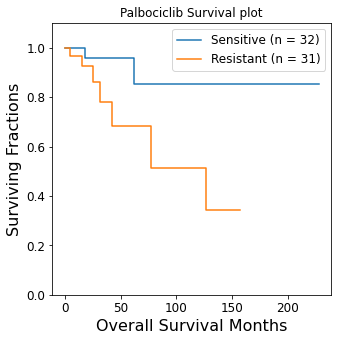

In [40]:
drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
print('Sample size:', len(genie_drug_data))
genie_drug_data.reset_index(drop=True, inplace=True)

survival_df, km_fig_palbo = genie_analysis_majority(test_data, genie_drug_data, drug, fraction=0.5, resp_th=4)

In [41]:
km_fig_palbo.savefig('../plots/figure6/survival_' + drug + '.svg')

Sample size: 349
p-value: 0.7155
Median Survival (Sensitive): 51.5
Median Survival (Resistant): 51.7


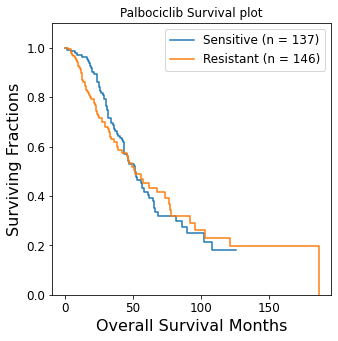

In [15]:
drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']

pos_samples = list(genie_drug_data['Sample_ID'])
genie_non_drug_data = genie_data.query("Sample_ID not in @pos_samples").copy()
print('Sample size:', len(genie_non_drug_data))
genie_non_drug_data.reset_index(drop=True, inplace=True)

survival_df, km_fig_non_palbo = genie_analysis_majority(test_data, genie_non_drug_data, drug, fraction=0.5, resp_th=4)

In [16]:
km_fig_non_palbo.savefig('../plots/figure6/survival_non_' + drug + '.svg')

Sample size: 79
p-value: 0.9541
Median Survival (Sensitive): inf
Median Survival (Resistant): inf


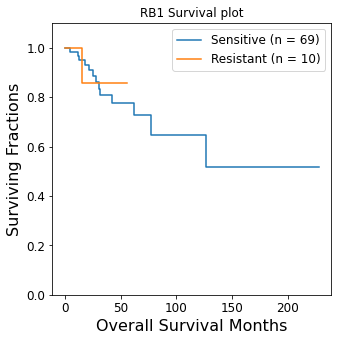

In [26]:
drug = 'Palbociclib'
gene = 'RB1'

mutations = pd.read_csv('../data/GENIE/cell2mutation_428.txt', header=None, names=gene_list)[gene]
cn_deletions = pd.read_csv('../data/GENIE/cell2cndeletion_428.txt', header=None, names=gene_list)[gene]
gene_alterations = np.array(mutations | cn_deletions)
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
print('Sample size:', len(genie_drug_data))
genie_drug_data.reset_index(drop=True, inplace=True)

survival_df, km_fig_palbo_rb1 = genie_analysis_gene(gene_alterations, sample_map, genie_drug_data, gene, is_resistant=True)

In [30]:
km_fig_palbo_rb1.savefig('../plots/figure6/survival_rb1_' + drug + '.svg')

Sample size: 349
p-value: 0.3878
Median Survival (Sensitive): 51.5
Median Survival (Resistant): 47.1


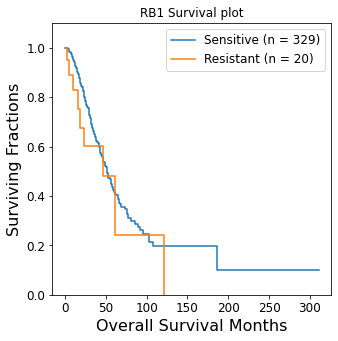

In [23]:
drug = 'Palbociclib'
gene = 'RB1'

mutations = pd.read_csv('../data/GENIE/cell2mutation_428.txt', header=None, names=gene_list)[gene]
cn_deletions = pd.read_csv('../data/GENIE/cell2cndeletion_428.txt', header=None, names=gene_list)[gene]
gene_alterations = np.array(mutations | cn_deletions)
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']

pos_samples = list(genie_drug_data['Sample_ID'])
genie_non_drug_data = genie_data.query("Sample_ID not in @pos_samples").copy()
print('Sample size:', len(genie_non_drug_data))
genie_non_drug_data.reset_index(drop=True, inplace=True)

survival_df, km_fig_non_palbo_rb1 = genie_analysis_gene(gene_alterations, sample_map, genie_non_drug_data, gene, is_resistant=True)

Sample size: 79
p-value: 0.7785
Median Survival (Sensitive): inf
Median Survival (Resistant): inf


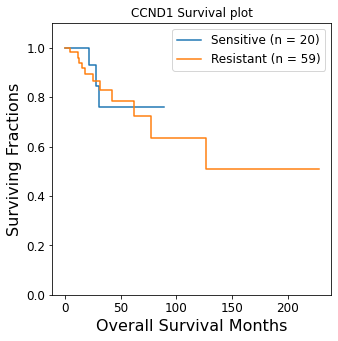

In [36]:
drug = 'Palbociclib'
gene = 'CCND1'

cn_amplifications = pd.read_csv('../data/GENIE/cell2cnamplification_428.txt', header=None, names=gene_list)[gene]
gene_alterations = np.array(cn_amplifications)
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
print('Sample size:', len(genie_drug_data))
genie_drug_data.reset_index(drop=True, inplace=True)

survival_df, km_fig_palbo_ccnd1 = genie_analysis_gene(gene_alterations, sample_map, genie_drug_data, gene, is_resistant=False)

In [31]:
km_fig_palbo_ccnd1.savefig('../plots/figure6/survival_ccnd1_' + drug + '.svg')

Sample size: 349
p-value: 0.2621
Median Survival (Sensitive): 47.1
Median Survival (Resistant): 52.3


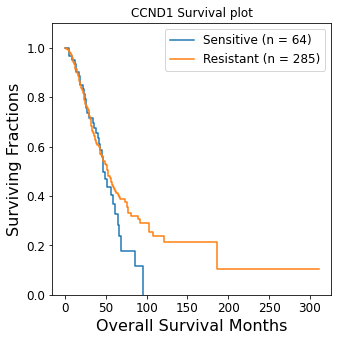

In [25]:
drug = 'Palbociclib'
gene = 'CCND1'

cn_amplifications = pd.read_csv('../data/GENIE/cell2cnamplification_428.txt', header=None, names=gene_list)[gene]
gene_alterations = np.array(cn_amplifications)
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']

pos_samples = list(genie_drug_data['Sample_ID'])
genie_non_drug_data = genie_data.query("Sample_ID not in @pos_samples").copy()
print('Sample size:', len(genie_non_drug_data))
genie_non_drug_data.reset_index(drop=True, inplace=True)

survival_df, km_fig_non_palbo_ccnd1 = genie_analysis_gene(gene_alterations, sample_map, genie_non_drug_data, gene, is_resistant=False)

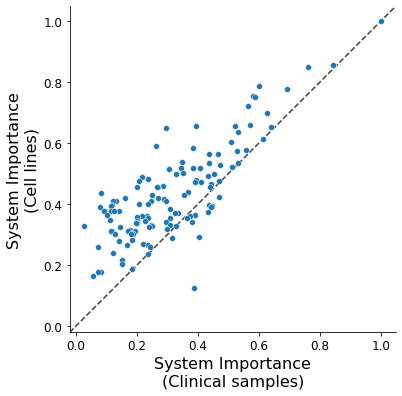

In [75]:
cl_rlipp_df = pd.read_csv('../models/rlipp/' + drug + '.txt', sep='\t')[['Term', 'Name', 'P_rho']]
genie_rlipp_df = pd.read_csv('../models/rlipp/' + drug + '_genie_428.txt', sep='\t')[['Term', 'Name', 'P_rho']]

merged_df = pd.merge(cl_rlipp_df, genie_rlipp_df, on=['Term', 'Name'], suffixes=('_cl', '_genie'))
merged_df.dropna(inplace=True)
scatterplot_sys = create_scatter_plot(merged_df['P_rho_genie'], merged_df['P_rho_cl'], 'System Importance\n(Clinical samples)', 'System Importance\n(Cell lines)')

In [76]:
print('Spearman rho:', stats.spearmanr(merged_df['P_rho_cl'], merged_df['P_rho_genie'])[0])

Spearman rho: 0.7089458715572851


In [77]:
scatterplot_sys.savefig('../plots/figure6/scatterplot_sysmtem_importance.svg')

In [67]:
merged_df.query("Term == 'NEST:91'")

,Term,Name,P_rho_cl,P_rho_genie
15,NEST:91,NEST:91,0.6132,0.6134


In [43]:
#print(genie_drug_data.columns)

In [ ]:
km_fig.savefig('../plots/genie_survival_plot_' + str(k) + '.svg')    